[Step 10/100] Immediate Loss: 133.2505471915007 Accumlated Loss: 151.00078135699033
[Step 20/100] Immediate Loss: 131.09676937043668 Accumlated Loss: 131.77195127099753
[Step 30/100] Immediate Loss: 130.5309797182679 Accumlated Loss: 130.8939816444516
[Step 40/100] Immediate Loss: 130.90671580255034 Accumlated Loss: 130.66879585793612
[Step 50/100] Immediate Loss: 130.40981076270342 Accumlated Loss: 130.5509652917683
[Step 60/100] Immediate Loss: 130.4613345116377 Accumlated Loss: 130.49925536295774
[Step 70/100] Immediate Loss: 130.44797495543955 Accumlated Loss: 130.4517231901586
[Step 80/100] Immediate Loss: 130.47368122369053 Accumlated Loss: 130.4738130722344
[Step 90/100] Immediate Loss: 130.42225397557016 Accumlated Loss: 130.38270727610586
[Step 100/100] Immediate Loss: 130.53060866862532 Accumlated Loss: 130.35955410438777


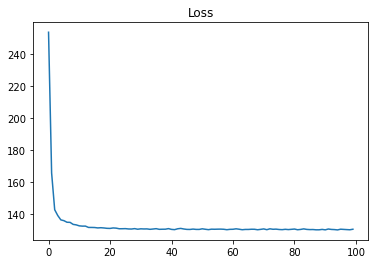

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import pyro
import pyro.contrib.examples.polyphonic_data_loader as poly
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from matplotlib import pyplot as plt
from made import MADE
from pyro.infer.autoguide import AutoDiagonalNormal, AutoNormal, AutoMultivariateNormal

random.seed(123)
torch.manual_seed(123)

# NN used for p(x | y)
class simpleNN(nn.Module):
    def __init__(self, input_size=1, hidden=32, out_size=1, t="normal", out_non_linear=None):
        super().__init__()
        self.t = t
        self.out_non_linear = out_non_linear
        self.hiddeen_layer = nn.Linear(input_size, hidden)
        if t == "normal":
            self.loc_layer = nn.Linear(hidden, out_size)
            self.std_layer = nn.Linear(hidden, out_size)
            self.softplus = nn.Softplus()
        elif t == "bern":
            self.prob_layer = nn.Linear(hidden, out_size)
        elif t == "mlp":
            self.out_layer = nn.Linear(hidden, out_size)
        
    def forward(self, x_list):
        for i in range(len(x_list)):
            if x_list[i].dim() == 0:
                x_list[i] = torch.unsqueeze(x_list[i], dim=0)
        input_x = torch.cat(x_list)
        hid = F.relu(self.hiddeen_layer(input_x))
        # return loc, std
        if self.t == "normal":
            return self.loc_layer(hid), self.softplus(self.std_layer(hid))
        elif self.t == "bern":
            return torch.sigmoid(self.prob_layer(hid))
        else:
            if self.out_non_linear == "tanh":
                return torch.tanh(self.out_layer(hid))
            else:
                return self.out_layer(hid)

class Experiment(nn.Module):
    def __init__(self):
        super().__init__()
        
        # guide 1
        self.hidden_size_1 = 8
        self.x1_net_1 = simpleNN()
        self.x2_net_1 = simpleNN()
        self.x3_net_1 = simpleNN()
        self.x4_net_1 = simpleNN()
        self.x5_net_1 = simpleNN()
        self.x6_net_1 = simpleNN()
        self.x7_net_1 = simpleNN()
        self.x8_net_1 = simpleNN()
        self.y1_net_1 = simpleNN()
        self.y2_net_1 = simpleNN()
        self.y3_net_1 = simpleNN()
        self.y4_net_1 = simpleNN()
        self.z1_net_1 = simpleNN(self.hidden_size_1 + 1)
        self.z2_net_1 = simpleNN(self.hidden_size_1 + 1)
        
        self.h0_1 = nn.Parameter(torch.zeros(self.hidden_size_1))
        self.hid_net_1 = simpleNN(self.hidden_size_1 + 8, out_size = self.hidden_size_1, t = "mlp")
        
        # guide 2
        self.hidden_size_2 = 8
        self.x1_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.x2_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.x3_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.x4_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.x5_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.x6_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.x7_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.x8_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.y1_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.y2_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.y3_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.y4_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.z1_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.z2_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.h0_2 = nn.Parameter(torch.zeros(self.hidden_size_2))
        self.hid_net_2 = simpleNN(self.hidden_size_2 + 8, out_size = self.hidden_size_2, t = "mlp")
        
        # guide 3
        self.hidden_size_3 = 8
        self.x1_net_3 = simpleNN(self.hidden_size_3 + 2)
        self.x2_net_3 = simpleNN(self.hidden_size_3 + 1)
        self.x3_net_3 = simpleNN(self.hidden_size_3 + 2)
        self.x4_net_3 = simpleNN(self.hidden_size_3 + 1)
        self.x5_net_3 = simpleNN(self.hidden_size_3 + 2)
        self.x6_net_3 = simpleNN(self.hidden_size_3 + 1)
        self.x7_net_3 = simpleNN(self.hidden_size_3 + 2)
        self.x8_net_3 = simpleNN(self.hidden_size_3 + 1)
        self.y1_net_3 = simpleNN(self.hidden_size_3 + 2)
        self.y2_net_3 = simpleNN(self.hidden_size_3 + 1)
        self.y3_net_3 = simpleNN(self.hidden_size_3 + 2)
        self.y4_net_3 = simpleNN(self.hidden_size_3 + 1)
        self.z1_net_3 = simpleNN(self.hidden_size_3 + 2)
        self.z2_net_3 = simpleNN(self.hidden_size_3 + 1)
        self.h0_3 = nn.Parameter(torch.zeros(self.hidden_size_3))
        self.hid_net_3 = simpleNN(self.hidden_size_3 + 8, out_size = self.hidden_size_3, t = "mlp")

        # guide 4
        self.hidden_size_4 = 8
        self.x1_net_4 = simpleNN(self.hidden_size_4 + 2)
        self.x2_net_4 = simpleNN(self.hidden_size_4 + 1)
        self.x3_net_4 = simpleNN(self.hidden_size_4 + 2)
        self.x4_net_4 = simpleNN(self.hidden_size_4 + 1)
        self.x5_net_4 = simpleNN(self.hidden_size_4 + 2)
        self.x6_net_4 = simpleNN(self.hidden_size_4 + 1)
        self.x7_net_4 = simpleNN(self.hidden_size_4 + 2)
        self.x8_net_4 = simpleNN(self.hidden_size_4 + 1)
        self.y1_net_4 = simpleNN(self.hidden_size_4 + 2)
        self.y2_net_4 = simpleNN(self.hidden_size_4 + 1)
        self.y3_net_4 = simpleNN(self.hidden_size_4 + 2)
        self.y4_net_4 = simpleNN(self.hidden_size_4 + 1)
        self.z1_net_4 = simpleNN(self.hidden_size_4 + 2)
        self.z2_net_4 = simpleNN(self.hidden_size_4 + 1)
        self.h0_4 = nn.Parameter(torch.zeros(self.hidden_size_4))
        self.hid_net_4 = simpleNN(self.hidden_size_4 + 8 + 4 + 2, out_size = self.hidden_size_4, t = "mlp")
        
        # guide 5
        self.hidden_size_5 = 16
        self.x1_net_5 = simpleNN(self.hidden_size_5 + 2)
        self.x2_net_5 = simpleNN(self.hidden_size_5 + 1)
        self.x3_net_5 = simpleNN(self.hidden_size_5 + 2)
        self.x4_net_5 = simpleNN(self.hidden_size_5 + 1)
        self.x5_net_5 = simpleNN(self.hidden_size_5 + 2)
        self.x6_net_5 = simpleNN(self.hidden_size_5 + 1)
        self.x7_net_5 = simpleNN(self.hidden_size_5 + 2)
        self.x8_net_5 = simpleNN(self.hidden_size_5 + 1)
        self.y1_net_5 = simpleNN(self.hidden_size_5 + 2)
        self.y2_net_5 = simpleNN(self.hidden_size_5 + 1)
        self.y3_net_5 = simpleNN(self.hidden_size_5 + 2)
        self.y4_net_5 = simpleNN(self.hidden_size_5 + 1)
        self.z1_net_5 = simpleNN(self.hidden_size_5 + 2)
        self.z2_net_5 = simpleNN(self.hidden_size_5 + 1)
        self.h0_5 = nn.Parameter(torch.zeros(self.hidden_size_5))
        self.hid_net_5 = simpleNN(self.hidden_size_5 + 8 + 4 + 2, out_size = self.hidden_size_5, t = "mlp")
        
        # guide 6
        self.hidden_size_6 = 8
        self.x1_net_6 = simpleNN(self.hidden_size_6 + 2)
        self.x2_net_6 = simpleNN(self.hidden_size_6 + 1)
        self.x3_net_6 = simpleNN(self.hidden_size_6 + 2)
        self.x4_net_6 = simpleNN(self.hidden_size_6 + 1)
        self.x5_net_6 = simpleNN(self.hidden_size_6 + 2)
        self.x6_net_6 = simpleNN(self.hidden_size_6 + 1)
        self.x7_net_6 = simpleNN(self.hidden_size_6 + 2)
        self.x8_net_6 = simpleNN(self.hidden_size_6 + 1)
        self.y1_net_6 = simpleNN(self.hidden_size_6 + 2)
        self.y2_net_6 = simpleNN(self.hidden_size_6 + 1)
        self.y3_net_6 = simpleNN(self.hidden_size_6 + 2)
        self.y4_net_6 = simpleNN(self.hidden_size_6 + 1)
        self.z1_net_6 = simpleNN(self.hidden_size_6 + 2)
        self.z2_net_6 = simpleNN(self.hidden_size_6 + 1)
        self.h0_6 = nn.Parameter(torch.zeros(self.hidden_size_6))
        self.hid_net_6 = simpleNN(self.hidden_size_6 + 8 + 4 + 2 + 1, out_size = self.hidden_size_6, t = "mlp")
    
    def model(self, n, obses):
        def tree_model(i, mu):
            x1 = pyro.sample(f"x1{i}", dist.Normal(mu, 1.0))
            x2 = pyro.sample(f"x2{i}", dist.Normal(mu, 1.0))
            x3 = pyro.sample(f"x3{i}", dist.Normal(mu, 1.0))
            x4 = pyro.sample(f"x4{i}", dist.Normal(mu, 1.0))
            x5 = pyro.sample(f"x5{i}", dist.Normal(mu, 1.0))
            x6 = pyro.sample(f"x6{i}", dist.Normal(mu, 1.0))
            x7 = pyro.sample(f"x7{i}", dist.Normal(mu, 1.0))
            x8 = pyro.sample(f"x8{i}", dist.Normal(mu, 1.0))
            y1 = pyro.sample(f"y1{i}", dist.Normal(x1+x2, 1.0))
            y2 = pyro.sample(f"y2{i}", dist.Normal(x3+x4, 1.0))
            y3 = pyro.sample(f"y3{i}", dist.Normal(x5+x6, 1.0))
            y4 = pyro.sample(f"y4{i}", dist.Normal(x7+x8, 1.0))
            z1 = pyro.sample(f"z1{i}", dist.Normal(y1+y2, 1.0))
            z2 = pyro.sample(f"z2{i}", dist.Normal(y3+y4, 1.0))
            return pyro.sample(f"obs{i}", dist.Normal(z1+z2, 1.0), obs=obses[i])
            
        pyro.module("model", self)
        mu = 0
        for i in range(n):
            mu = tree_model(i, mu)
    
    # guide 1 basically inverse the arrows in the model, add hidden states that z2 depends on
    # hid dependes on its old values and all sampled xs (x1,x2...x8)
    # sample from i = 0, 1, ..., n-2, n-1
    def guide_1(self, n, obses):
        
        def tree_guide(i, hid):
            z2_mean, z2_std = self.z2_net_1([obses[i], hid])
            z2 = pyro.sample(f"z2{i}", dist.Normal(z2_mean, z2_std))
            z1_mean, z1_std = self.z1_net_1([obses[i], hid])
            z1 = pyro.sample(f"z1{i}", dist.Normal(z1_mean, z1_std))
            y4_mean, y4_std = self.y4_net_1([z2])
            y4 = pyro.sample(f"y4{i}", dist.Normal(y4_mean, y4_std))
            y3_mean, y3_std = self.y3_net_1([z2])
            y3 = pyro.sample(f"y3{i}", dist.Normal(y3_mean, y3_std))
            y2_mean, y2_std = self.y2_net_1([z1])
            y2 = pyro.sample(f"y2{i}", dist.Normal(y2_mean, y2_std))
            y1_mean, y1_std = self.y1_net_1([z1])
            y1 = pyro.sample(f"y1{i}", dist.Normal(y1_mean, y1_std))
            x8_mean, x8_std = self.x8_net_1([y4])
            x8 = pyro.sample(f"x8{i}", dist.Normal(x8_mean, x8_std))
            x7_mean, x7_std = self.x7_net_1([y4])
            x7 = pyro.sample(f"x7{i}", dist.Normal(x7_mean, x7_std))
            x6_mean, x6_std = self.x6_net_1([y3])
            x6 = pyro.sample(f"x6{i}", dist.Normal(x6_mean, x6_std))
            x5_mean, x5_std = self.x5_net_1([y3])
            x5 = pyro.sample(f"x5{i}", dist.Normal(x5_mean, x5_std))
            x4_mean, x4_std = self.x4_net_1([y2])
            x4 = pyro.sample(f"x4{i}", dist.Normal(x4_mean, x4_std))
            x3_mean, x3_std = self.x3_net_1([y2])
            x3 = pyro.sample(f"x3{i}", dist.Normal(x3_mean, x3_std))
            x2_mean, x2_std = self.x2_net_1([y1])
            x2 = pyro.sample(f"x2{i}", dist.Normal(x2_mean, x2_std))
            x1_mean, x1_std = self.x1_net_1([y1])
            x1 = pyro.sample(f"x1{i}", dist.Normal(x1_mean, x1_std))
            hid = self.hid_net_1([hid, x1, x2, x3, x4, x5, x6, x7, x8])
            return hid
            
        pyro.module("model", self)
        hid = self.h0_1
        for i in range(n):
            hid = tree_guide(i, hid)
    
    # guide_1_1 basically inverse the arrows in the model, add hidden states that z2 depends on
    # hid dependes on its old values and all sampled xs (x1,x2...x8)
    # different from guide_1 by sample from i = n-1, n-2, ..., 0
    def guide_1_1(self, n, obses):
        
        def tree_guide(i, hid):
            z2_mean, z2_std = self.z2_net_1([obses[i], hid])
            z2 = pyro.sample(f"z2{i}", dist.Normal(z2_mean, z2_std))
            z1_mean, z1_std = self.z1_net_1([obses[i], hid])
            z1 = pyro.sample(f"z1{i}", dist.Normal(z1_mean, z1_std))
            y4_mean, y4_std = self.y4_net_1([z2])
            y4 = pyro.sample(f"y4{i}", dist.Normal(y4_mean, y4_std))
            y3_mean, y3_std = self.y3_net_1([z2])
            y3 = pyro.sample(f"y3{i}", dist.Normal(y3_mean, y3_std))
            y2_mean, y2_std = self.y2_net_1([z1])
            y2 = pyro.sample(f"y2{i}", dist.Normal(y2_mean, y2_std))
            y1_mean, y1_std = self.y1_net_1([z1])
            y1 = pyro.sample(f"y1{i}", dist.Normal(y1_mean, y1_std))
            x8_mean, x8_std = self.x8_net_1([y4])
            x8 = pyro.sample(f"x8{i}", dist.Normal(x8_mean, x8_std))
            x7_mean, x7_std = self.x7_net_1([y4])
            x7 = pyro.sample(f"x7{i}", dist.Normal(x7_mean, x7_std))
            x6_mean, x6_std = self.x6_net_1([y3])
            x6 = pyro.sample(f"x6{i}", dist.Normal(x6_mean, x6_std))
            x5_mean, x5_std = self.x5_net_1([y3])
            x5 = pyro.sample(f"x5{i}", dist.Normal(x5_mean, x5_std))
            x4_mean, x4_std = self.x4_net_1([y2])
            x4 = pyro.sample(f"x4{i}", dist.Normal(x4_mean, x4_std))
            x3_mean, x3_std = self.x3_net_1([y2])
            x3 = pyro.sample(f"x3{i}", dist.Normal(x3_mean, x3_std))
            x2_mean, x2_std = self.x2_net_1([y1])
            x2 = pyro.sample(f"x2{i}", dist.Normal(x2_mean, x2_std))
            x1_mean, x1_std = self.x1_net_1([y1])
            x1 = pyro.sample(f"x1{i}", dist.Normal(x1_mean, x1_std))
            hid = self.hid_net_1([hid, x1, x2, x3, x4, x5, x6, x7, x8])
            return hid
            
        pyro.module("model", self)
        hid = self.h0_1
        for i in range(n-1, -1, -1):
            hid = tree_guide(i, hid)
    
    # guide 2 basically inverse the arrows in the model, add hidden states that each RV
    # hid dependes on its old values and all sampled xs (x1,x2...x8)
    # sample from i = 0, 1, ..., n-2, n-1
    def guide_2(self, n, obs):
        def tree_guide(i, hid):
            z2_mean, z2_std = self.z2_net_2([obses[i], hid])
            z2 = pyro.sample(f"z2{i}", dist.Normal(z2_mean, z2_std))
            z1_mean, z1_std = self.z1_net_2([obses[i], hid])
            z1 = pyro.sample(f"z1{i}", dist.Normal(z1_mean, z1_std))
            y4_mean, y4_std = self.y4_net_2([z2, hid])
            y4 = pyro.sample(f"y4{i}", dist.Normal(y4_mean, y4_std))
            y3_mean, y3_std = self.y3_net_2([z2, hid])
            y3 = pyro.sample(f"y3{i}", dist.Normal(y3_mean, y3_std))
            y2_mean, y2_std = self.y2_net_2([z1, hid])
            y2 = pyro.sample(f"y2{i}", dist.Normal(y2_mean, y2_std))
            y1_mean, y1_std = self.y1_net_2([z1, hid])
            y1 = pyro.sample(f"y1{i}", dist.Normal(y1_mean, y1_std))
            x8_mean, x8_std = self.x8_net_2([y4, hid])
            x8 = pyro.sample(f"x8{i}", dist.Normal(x8_mean, x8_std))
            x7_mean, x7_std = self.x7_net_2([y4, hid])
            x7 = pyro.sample(f"x7{i}", dist.Normal(x7_mean, x7_std))
            x6_mean, x6_std = self.x6_net_2([y3, hid])
            x6 = pyro.sample(f"x6{i}", dist.Normal(x6_mean, x6_std))
            x5_mean, x5_std = self.x5_net_2([y3, hid])
            x5 = pyro.sample(f"x5{i}", dist.Normal(x5_mean, x5_std))
            x4_mean, x4_std = self.x4_net_2([y2, hid])
            x4 = pyro.sample(f"x4{i}", dist.Normal(x4_mean, x4_std))
            x3_mean, x3_std = self.x3_net_2([y2, hid])
            x3 = pyro.sample(f"x3{i}", dist.Normal(x3_mean, x3_std))
            x2_mean, x2_std = self.x2_net_2([y1, hid])
            x2 = pyro.sample(f"x2{i}", dist.Normal(x2_mean, x2_std))
            x1_mean, x1_std = self.x1_net_2([y1, hid])
            x1 = pyro.sample(f"x1{i}", dist.Normal(x1_mean, x1_std))
            hid = self.hid_net_2([hid, x1, x2, x3, x4, x5, x6, x7, x8])
            return hid
            
        pyro.module("model", self)
        hid = self.h0_2
        for i in range(n):
            hid = tree_guide(i, hid)
    
    # guide 3 basically inverse the arrows in the model, add hidden states that each RV
    # each RV also dependes on its neighbour at the same level
    # similar to guide_4 in tree
    # hid dependes on its old values and all sampled xs (x1,x2...x8)
    # sample from i = 0, 1, ..., n-2, n-1
    
    def guide_3(self, n, obs):
        def tree_guide(i, hid):
            z2_mean, z2_std = self.z2_net_3([obses[i], hid])
            z2 = pyro.sample(f"z2{i}", dist.Normal(z2_mean, z2_std))
            z1_mean, z1_std = self.z1_net_3([obses[i], hid, z2])
            z1 = pyro.sample(f"z1{i}", dist.Normal(z1_mean, z1_std))
            y4_mean, y4_std = self.y4_net_3([z2, hid])
            y4 = pyro.sample(f"y4{i}", dist.Normal(y4_mean, y4_std))
            y3_mean, y3_std = self.y3_net_3([z2, hid, y4])
            y3 = pyro.sample(f"y3{i}", dist.Normal(y3_mean, y3_std))
            y2_mean, y2_std = self.y2_net_3([z1, hid])
            y2 = pyro.sample(f"y2{i}", dist.Normal(y2_mean, y2_std))
            y1_mean, y1_std = self.y1_net_3([z1, hid, y2])
            y1 = pyro.sample(f"y1{i}", dist.Normal(y1_mean, y1_std))
            x8_mean, x8_std = self.x8_net_3([y4, hid])
            x8 = pyro.sample(f"x8{i}", dist.Normal(x8_mean, x8_std))
            x7_mean, x7_std = self.x7_net_3([y4, hid, x8])
            x7 = pyro.sample(f"x7{i}", dist.Normal(x7_mean, x7_std))
            x6_mean, x6_std = self.x6_net_3([y3, hid])
            x6 = pyro.sample(f"x6{i}", dist.Normal(x6_mean, x6_std))
            x5_mean, x5_std = self.x5_net_3([y3, hid, x6])
            x5 = pyro.sample(f"x5{i}", dist.Normal(x5_mean, x5_std))
            x4_mean, x4_std = self.x4_net_3([y2, hid])
            x4 = pyro.sample(f"x4{i}", dist.Normal(x4_mean, x4_std))
            x3_mean, x3_std = self.x3_net_3([y2, hid, x4])
            x3 = pyro.sample(f"x3{i}", dist.Normal(x3_mean, x3_std))
            x2_mean, x2_std = self.x2_net_3([y1, hid])
            x2 = pyro.sample(f"x2{i}", dist.Normal(x2_mean, x2_std))
            x1_mean, x1_std = self.x1_net_3([y1, hid, x2])
            x1 = pyro.sample(f"x1{i}", dist.Normal(x1_mean, x1_std))
            hid = self.hid_net_3([hid, x1, x2, x3, x4, x5, x6, x7, x8])
            return hid
            
        pyro.module("model", self)
        hid = self.h0_3
        for i in range(n):
            hid = tree_guide(i, hid)
    
    # guide 3_1 basically inverse the arrows in the model, add hidden states that each RV
    # each RV also dependes on its neighbour at the same level
    # similar to guide_4 in tree
    # hid dependes on its old values and all sampled xs (x1,x2...x8)
    # sample from i = n-1, n-2, ..., 1, 0
    
    def guide_3_1(self, n, obs):
        def tree_guide(i, hid):
            z2_mean, z2_std = self.z2_net_3([obses[i], hid])
            z2 = pyro.sample(f"z2{i}", dist.Normal(z2_mean, z2_std))
            z1_mean, z1_std = self.z1_net_3([obses[i], hid, z2])
            z1 = pyro.sample(f"z1{i}", dist.Normal(z1_mean, z1_std))
            y4_mean, y4_std = self.y4_net_3([z2, hid])
            y4 = pyro.sample(f"y4{i}", dist.Normal(y4_mean, y4_std))
            y3_mean, y3_std = self.y3_net_3([z2, hid, y4])
            y3 = pyro.sample(f"y3{i}", dist.Normal(y3_mean, y3_std))
            y2_mean, y2_std = self.y2_net_3([z1, hid])
            y2 = pyro.sample(f"y2{i}", dist.Normal(y2_mean, y2_std))
            y1_mean, y1_std = self.y1_net_3([z1, hid, y2])
            y1 = pyro.sample(f"y1{i}", dist.Normal(y1_mean, y1_std))
            x8_mean, x8_std = self.x8_net_3([y4, hid])
            x8 = pyro.sample(f"x8{i}", dist.Normal(x8_mean, x8_std))
            x7_mean, x7_std = self.x7_net_3([y4, hid, x8])
            x7 = pyro.sample(f"x7{i}", dist.Normal(x7_mean, x7_std))
            x6_mean, x6_std = self.x6_net_3([y3, hid])
            x6 = pyro.sample(f"x6{i}", dist.Normal(x6_mean, x6_std))
            x5_mean, x5_std = self.x5_net_3([y3, hid, x6])
            x5 = pyro.sample(f"x5{i}", dist.Normal(x5_mean, x5_std))
            x4_mean, x4_std = self.x4_net_3([y2, hid])
            x4 = pyro.sample(f"x4{i}", dist.Normal(x4_mean, x4_std))
            x3_mean, x3_std = self.x3_net_3([y2, hid, x4])
            x3 = pyro.sample(f"x3{i}", dist.Normal(x3_mean, x3_std))
            x2_mean, x2_std = self.x2_net_3([y1, hid])
            x2 = pyro.sample(f"x2{i}", dist.Normal(x2_mean, x2_std))
            x1_mean, x1_std = self.x1_net_3([y1, hid, x2])
            x1 = pyro.sample(f"x1{i}", dist.Normal(x1_mean, x1_std))
            hid = self.hid_net_3([hid, x1, x2, x3, x4, x5, x6, x7, x8])
            return hid
            
        pyro.module("model", self)
        hid = self.h0_3
        for i in range(n-1, -1, -1):
            hid = tree_guide(i, hid)
    
    # guide 4 basically inverse the arrows in the model, add hidden states that each RV
    # each RV also dependes on its neighbour at the same level
    # similar to guide_4 in tree
    # hid dependes on its old values and all sampled RVs in current iteration (x1,x2...x8, y1,...y4, z1,z2)
    # sample from i = 0, 1, ..., n-2, n-1
    
    def guide_4(self, n, obs):
        def tree_guide(i, hid):
            z2_mean, z2_std = self.z2_net_4([obses[i], hid])
            z2 = pyro.sample(f"z2{i}", dist.Normal(z2_mean, z2_std))
            z1_mean, z1_std = self.z1_net_4([obses[i], hid, z2])
            z1 = pyro.sample(f"z1{i}", dist.Normal(z1_mean, z1_std))
            y4_mean, y4_std = self.y4_net_4([z2, hid])
            y4 = pyro.sample(f"y4{i}", dist.Normal(y4_mean, y4_std))
            y3_mean, y3_std = self.y3_net_4([z2, hid, y4])
            y3 = pyro.sample(f"y3{i}", dist.Normal(y3_mean, y3_std))
            y2_mean, y2_std = self.y2_net_4([z1, hid])
            y2 = pyro.sample(f"y2{i}", dist.Normal(y2_mean, y2_std))
            y1_mean, y1_std = self.y1_net_4([z1, hid, y2])
            y1 = pyro.sample(f"y1{i}", dist.Normal(y1_mean, y1_std))
            x8_mean, x8_std = self.x8_net_4([y4, hid])
            x8 = pyro.sample(f"x8{i}", dist.Normal(x8_mean, x8_std))
            x7_mean, x7_std = self.x7_net_4([y4, hid, x8])
            x7 = pyro.sample(f"x7{i}", dist.Normal(x7_mean, x7_std))
            x6_mean, x6_std = self.x6_net_4([y3, hid])
            x6 = pyro.sample(f"x6{i}", dist.Normal(x6_mean, x6_std))
            x5_mean, x5_std = self.x5_net_4([y3, hid, x6])
            x5 = pyro.sample(f"x5{i}", dist.Normal(x5_mean, x5_std))
            x4_mean, x4_std = self.x4_net_4([y2, hid])
            x4 = pyro.sample(f"x4{i}", dist.Normal(x4_mean, x4_std))
            x3_mean, x3_std = self.x3_net_4([y2, hid, x4])
            x3 = pyro.sample(f"x3{i}", dist.Normal(x3_mean, x3_std))
            x2_mean, x2_std = self.x2_net_4([y1, hid])
            x2 = pyro.sample(f"x2{i}", dist.Normal(x2_mean, x2_std))
            x1_mean, x1_std = self.x1_net_4([y1, hid, x2])
            x1 = pyro.sample(f"x1{i}", dist.Normal(x1_mean, x1_std))
            hid = self.hid_net_4([hid, x1, x2, x3, x4, x5, x6, x7, x8, y1, y2, y3, y4, z1, z2])
            return hid
            
        pyro.module("model", self)
        hid = self.h0_4
        for i in range(n):
            hid = tree_guide(i, hid)
    
    # guide 5 basically inverse the arrows in the model, add hidden states that each RV
    # each RV also dependes on its neighbour at the same level
    # similar to guide_4 in tree
    # hid dependes on its old values and all sampled RVs in current iteration (x1,x2...x8, y1,...y4, z1,z2)
    # sample from i = 0, 1, ..., n-2, n-1
    # increases hidden state dim from 8 to 16
    def guide_5(self, n, obs):
        def tree_guide(i, hid):
            z2_mean, z2_std = self.z2_net_5([obses[i], hid])
            z2 = pyro.sample(f"z2{i}", dist.Normal(z2_mean, z2_std))
            z1_mean, z1_std = self.z1_net_5([obses[i], hid, z2])
            z1 = pyro.sample(f"z1{i}", dist.Normal(z1_mean, z1_std))
            y4_mean, y4_std = self.y4_net_5([z2, hid])
            y4 = pyro.sample(f"y4{i}", dist.Normal(y4_mean, y4_std))
            y3_mean, y3_std = self.y3_net_5([z2, hid, y4])
            y3 = pyro.sample(f"y3{i}", dist.Normal(y3_mean, y3_std))
            y2_mean, y2_std = self.y2_net_5([z1, hid])
            y2 = pyro.sample(f"y2{i}", dist.Normal(y2_mean, y2_std))
            y1_mean, y1_std = self.y1_net_5([z1, hid, y2])
            y1 = pyro.sample(f"y1{i}", dist.Normal(y1_mean, y1_std))
            x8_mean, x8_std = self.x8_net_5([y4, hid])
            x8 = pyro.sample(f"x8{i}", dist.Normal(x8_mean, x8_std))
            x7_mean, x7_std = self.x7_net_5([y4, hid, x8])
            x7 = pyro.sample(f"x7{i}", dist.Normal(x7_mean, x7_std))
            x6_mean, x6_std = self.x6_net_5([y3, hid])
            x6 = pyro.sample(f"x6{i}", dist.Normal(x6_mean, x6_std))
            x5_mean, x5_std = self.x5_net_5([y3, hid, x6])
            x5 = pyro.sample(f"x5{i}", dist.Normal(x5_mean, x5_std))
            x4_mean, x4_std = self.x4_net_5([y2, hid])
            x4 = pyro.sample(f"x4{i}", dist.Normal(x4_mean, x4_std))
            x3_mean, x3_std = self.x3_net_5([y2, hid, x4])
            x3 = pyro.sample(f"x3{i}", dist.Normal(x3_mean, x3_std))
            x2_mean, x2_std = self.x2_net_5([y1, hid])
            x2 = pyro.sample(f"x2{i}", dist.Normal(x2_mean, x2_std))
            x1_mean, x1_std = self.x1_net_5([y1, hid, x2])
            x1 = pyro.sample(f"x1{i}", dist.Normal(x1_mean, x1_std))
            hid = self.hid_net_5([hid, x1, x2, x3, x4, x5, x6, x7, x8, y1, y2, y3, y4, z1, z2])
            return hid
            
        pyro.module("model", self)
        hid = self.h0_5
        for i in range(n):
            hid = tree_guide(i, hid)
    
    # guide 6 basically inverse the arrows in the model, add hidden states that each RV
    # each RV also dependes on its neighbour at the same level
    # similar to guide_4 in tree
    # hid dependes on its old values and all sampled RVs in current iteration (x1,x2...x8, y1,...y4, z1,z2, obs)
    # sample from i = 0, 1, ..., n-2, n-1
    # different from guide_4 by adding obses[i] as an extra dependecy when updating hid

    def guide_6(self, n, obs):
        def tree_guide(i, hid):
            z2_mean, z2_std = self.z2_net_6([obses[i], hid])
            z2 = pyro.sample(f"z2{i}", dist.Normal(z2_mean, z2_std))
            z1_mean, z1_std = self.z1_net_6([obses[i], hid, z2])
            z1 = pyro.sample(f"z1{i}", dist.Normal(z1_mean, z1_std))
            y4_mean, y4_std = self.y4_net_6([z2, hid])
            y4 = pyro.sample(f"y4{i}", dist.Normal(y4_mean, y4_std))
            y3_mean, y3_std = self.y3_net_6([z2, hid, y4])
            y3 = pyro.sample(f"y3{i}", dist.Normal(y3_mean, y3_std))
            y2_mean, y2_std = self.y2_net_6([z1, hid])
            y2 = pyro.sample(f"y2{i}", dist.Normal(y2_mean, y2_std))
            y1_mean, y1_std = self.y1_net_6([z1, hid, y2])
            y1 = pyro.sample(f"y1{i}", dist.Normal(y1_mean, y1_std))
            x8_mean, x8_std = self.x8_net_6([y4, hid])
            x8 = pyro.sample(f"x8{i}", dist.Normal(x8_mean, x8_std))
            x7_mean, x7_std = self.x7_net_6([y4, hid, x8])
            x7 = pyro.sample(f"x7{i}", dist.Normal(x7_mean, x7_std))
            x6_mean, x6_std = self.x6_net_6([y3, hid])
            x6 = pyro.sample(f"x6{i}", dist.Normal(x6_mean, x6_std))
            x5_mean, x5_std = self.x5_net_6([y3, hid, x6])
            x5 = pyro.sample(f"x5{i}", dist.Normal(x5_mean, x5_std))
            x4_mean, x4_std = self.x4_net_6([y2, hid])
            x4 = pyro.sample(f"x4{i}", dist.Normal(x4_mean, x4_std))
            x3_mean, x3_std = self.x3_net_6([y2, hid, x4])
            x3 = pyro.sample(f"x3{i}", dist.Normal(x3_mean, x3_std))
            x2_mean, x2_std = self.x2_net_6([y1, hid])
            x2 = pyro.sample(f"x2{i}", dist.Normal(x2_mean, x2_std))
            x1_mean, x1_std = self.x1_net_6([y1, hid, x2])
            x1 = pyro.sample(f"x1{i}", dist.Normal(x1_mean, x1_std))
            hid = self.hid_net_6([hid, x1, x2, x3, x4, x5, x6, x7, x8, y1, y2, y3, y4, z1, z2, obses[i]])
            return hid
            
        pyro.module("model", self)
        hid = self.h0_6
        for i in range(n):
            hid = tree_guide(i, hid)
def generate_data():
    
    n_min = 2
    n_max = 4
    n = random.randint(n_min, n_max)
    obses = []
    mu = 0
    x_len = 8
    for i in range(n):
        x_noise = torch.randn(x_len) / 4
        x_mean = torch.zeros(x_len) + mu
        xs = torch.normal(x_mean, 1) + x_noise
        ys = []
        j = 0
        while j < len(xs):
            y = dist.Normal(xs[j] + xs[j+1], 2).sample()
            ys.append(y)
            j +=2
        
        zs = []
        j = 0
        while j < len(ys):
            z = dist.Normal(ys[j] + ys[j+1], 1.5).sample()
            zs.append(z)
            j +=2
        
        
        obs = dist.Normal(zs[0] + zs[1], 1).sample()
        obses.append(obs)
        
    return n, obses
    
        

data = []
num_data = 100
for _ in range(num_data):
    data.append(generate_data())

#print(data)
experiment = Experiment()
adam_params = {"lr": 0.001, "betas": (0.95, 0.999)}
optimizer = Adam(adam_params)
guide = experiment.guide_6 # guide_1

#guide = AutoNormal(experiment.model)
#guide = AutoMultivariateNormal(experiment.model)
#guide = AutoDiagonalNormal(experiment.model)

svi = SVI(experiment.model, guide, optimizer, loss=Trace_ELBO())


n_steps = 100
log_interval = 10
# do gradient steps
loss = 0
loss_track = []
for step in range(1, n_steps + 1):
    imme_loss = 0
    
    for n, obses in data:
        imme_loss += svi.step(n, obses) / num_data
        
    loss_track.append(imme_loss)
    loss += imme_loss / log_interval
    
    if step % log_interval == 0:
        print("[Step {}/{}] Immediate Loss: {} Accumlated Loss: {}".format(step, n_steps, imme_loss, loss))
        loss = 0
    
plt.plot(loss_track)
plt.title("Loss")
plt.show()
    

In [2]:
# guide 1
[Step 10/100] Immediate Loss: 205.02005288749922 Accumlated Loss: 229.93057604810593
[Step 20/100] Immediate Loss: 193.44546516716488 Accumlated Loss: 197.67716926190258
[Step 30/100] Immediate Loss: 189.72216062426574 Accumlated Loss: 192.7044314104617
[Step 40/100] Immediate Loss: 191.6670883595943 Accumlated Loss: 192.4000375045538
[Step 50/100] Immediate Loss: 192.85603537023067 Accumlated Loss: 191.965986341089
[Step 60/100] Immediate Loss: 189.7273656892775 Accumlated Loss: 191.2137057619691
[Step 70/100] Immediate Loss: 193.29120927006005 Accumlated Loss: 191.3552865049243
[Step 80/100] Immediate Loss: 191.55413781136275 Accumlated Loss: 190.50370052289958
[Step 90/100] Immediate Loss: 189.8036905479431 Accumlated Loss: 190.74393684166665
[Step 100/100] Immediate Loss: 191.4137462487817 Accumlated Loss: 191.34739547252656

SyntaxError: invalid syntax (<ipython-input-2-6002a8a76388>, line 2)

In [ ]:
# guide_1_1
[Step 10/100] Immediate Loss: 243.17567226558916 Accumlated Loss: 249.93117425850028
[Step 20/100] Immediate Loss: 244.72659548014403 Accumlated Loss: 242.8565336660445
[Step 30/100] Immediate Loss: 240.5080971556902 Accumlated Loss: 242.6165884468257
[Step 40/100] Immediate Loss: 242.08676910877227 Accumlated Loss: 242.84494205495716
[Step 50/100] Immediate Loss: 242.76524257272482 Accumlated Loss: 244.14858736667034
[Step 60/100] Immediate Loss: 241.0754128733278 Accumlated Loss: 242.2538581807018
[Step 70/100] Immediate Loss: 243.60054168164731 Accumlated Loss: 242.72385012498495
[Step 80/100] Immediate Loss: 242.04735180199143 Accumlated Loss: 242.54857986423377
[Step 90/100] Immediate Loss: 244.95454502999777 Accumlated Loss: 242.92264006292822
[Step 100/100] Immediate Loss: 240.45793809533114 Accumlated Loss: 241.56808622214197

In [ ]:
# guide 2
[Step 10/100] Immediate Loss: 161.72037420719855 Accumlated Loss: 206.97543536764383
[Step 20/100] Immediate Loss: 154.42872785031793 Accumlated Loss: 156.8636066983342
[Step 30/100] Immediate Loss: 154.89385166198016 Accumlated Loss: 155.554997610718
[Step 40/100] Immediate Loss: 152.9510755580663 Accumlated Loss: 153.27333305451273
[Step 50/100] Immediate Loss: 154.33259579449893 Accumlated Loss: 152.67802670937778
[Step 60/100] Immediate Loss: 151.32435389369724 Accumlated Loss: 152.40955043360594
[Step 70/100] Immediate Loss: 152.12359817773108 Accumlated Loss: 151.92007436320185
[Step 80/100] Immediate Loss: 151.63909643739467 Accumlated Loss: 151.64953022274378
[Step 90/100] Immediate Loss: 150.09802410513163 Accumlated Loss: 151.33765858772398
[Step 100/100] Immediate Loss: 151.99334681153297 Accumlated Loss: 151.38464494919774

In [ ]:
# guide 3
[Step 10/100] Immediate Loss: 156.54970044404274 Accumlated Loss: 205.49120853278043
[Step 20/100] Immediate Loss: 146.21416290223593 Accumlated Loss: 151.73081569635866
[Step 30/100] Immediate Loss: 145.99762244373565 Accumlated Loss: 148.037068867147
[Step 40/100] Immediate Loss: 144.90703502684838 Accumlated Loss: 146.81886969110366
[Step 50/100] Immediate Loss: 154.47853491395713 Accumlated Loss: 146.8090178412497
[Step 60/100] Immediate Loss: 144.7315254962444 Accumlated Loss: 145.9859772133231
[Step 70/100] Immediate Loss: 144.5153875619173 Accumlated Loss: 144.81224406862256
[Step 80/100] Immediate Loss: 145.71405132502315 Accumlated Loss: 144.49057878816132
[Step 90/100] Immediate Loss: 142.99038626790053 Accumlated Loss: 144.68658062565328
[Step 100/100] Immediate Loss: 144.86714501202107 Accumlated Loss: 144.51566709992287

In [ ]:
# guide 3_1
[Step 10/100] Immediate Loss: 237.95079532623285 Accumlated Loss: 244.41158370643853
[Step 20/100] Immediate Loss: 235.0609086954593 Accumlated Loss: 237.2647152982056
[Step 30/100] Immediate Loss: 239.3422497320175 Accumlated Loss: 237.2776778906882
[Step 40/100] Immediate Loss: 231.52443150669333 Accumlated Loss: 236.76619076043366
[Step 50/100] Immediate Loss: 236.21208954542874 Accumlated Loss: 235.64118742516632
[Step 60/100] Immediate Loss: 235.87248040288685 Accumlated Loss: 235.92637273627525
[Step 70/100] Immediate Loss: 234.67147369980813 Accumlated Loss: 235.32963036370276
[Step 80/100] Immediate Loss: 235.51996728897092 Accumlated Loss: 235.26592883837222
[Step 90/100] Immediate Loss: 235.32647399485114 Accumlated Loss: 235.39784914121034
[Step 100/100] Immediate Loss: 234.3285268226264 Accumlated Loss: 236.0535413537621

In [ ]:
# guide 4
[Step 10/100] Immediate Loss: 136.67552889168263 Accumlated Loss: 171.65901040324567
[Step 20/100] Immediate Loss: 134.46544417381284 Accumlated Loss: 136.2050290864408
[Step 30/100] Immediate Loss: 133.56331461280584 Accumlated Loss: 133.82781182029842
[Step 40/100] Immediate Loss: 133.42557626813652 Accumlated Loss: 133.1396080618799
[Step 50/100] Immediate Loss: 132.9371324226259 Accumlated Loss: 132.9935011680722
[Step 60/100] Immediate Loss: 132.42990424573418 Accumlated Loss: 132.64160733377935
[Step 70/100] Immediate Loss: 132.5175514909625 Accumlated Loss: 132.90345291566848
[Step 80/100] Immediate Loss: 132.891668445766 Accumlated Loss: 132.6192719244957
[Step 90/100] Immediate Loss: 132.40696921557188 Accumlated Loss: 132.36135414510966
[Step 100/100] Immediate Loss: 133.0058055579662 Accumlated Loss: 132.72950833249092

In [ ]:
# guide 5
[Step 10/100] Immediate Loss: 137.6395178815722 Accumlated Loss: 161.69517275613546
[Step 20/100] Immediate Loss: 134.848082999885 Accumlated Loss: 136.15659867483376
[Step 30/100] Immediate Loss: 133.76911400049923 Accumlated Loss: 134.251332498014
[Step 40/100] Immediate Loss: 133.32945654392245 Accumlated Loss: 133.28956336176395
[Step 50/100] Immediate Loss: 132.86999615460635 Accumlated Loss: 133.24745962142947
[Step 60/100] Immediate Loss: 132.82050257802007 Accumlated Loss: 133.2022660382092
[Step 70/100] Immediate Loss: 133.0186079853774 Accumlated Loss: 133.04267943680287
[Step 80/100] Immediate Loss: 132.48377571076156 Accumlated Loss: 132.91993908631804
[Step 90/100] Immediate Loss: 132.986798030138 Accumlated Loss: 132.58449679705498
[Step 100/100] Immediate Loss: 132.66238063335425 Accumlated Loss: 132.46512776604297

In [ ]:
### guide 6 ### best
[Step 10/100] Immediate Loss: 133.2505471915007 Accumlated Loss: 151.00078135699033
[Step 20/100] Immediate Loss: 131.09676937043668 Accumlated Loss: 131.77195127099753
[Step 30/100] Immediate Loss: 130.5309797182679 Accumlated Loss: 130.8939816444516
[Step 40/100] Immediate Loss: 130.90671580255034 Accumlated Loss: 130.66879585793612
[Step 50/100] Immediate Loss: 130.40981076270342 Accumlated Loss: 130.5509652917683
[Step 60/100] Immediate Loss: 130.4613345116377 Accumlated Loss: 130.49925536295774
[Step 70/100] Immediate Loss: 130.44797495543955 Accumlated Loss: 130.4517231901586
[Step 80/100] Immediate Loss: 130.47368122369053 Accumlated Loss: 130.4738130722344
[Step 90/100] Immediate Loss: 130.42225397557016 Accumlated Loss: 130.38270727610586
[Step 100/100] Immediate Loss: 130.53060866862532 Accumlated Loss: 130.35955410438777

In [ ]:
# AutoNormal
[Step 10/100] Immediate Loss: 1233.5509329861402 Accumlated Loss: 1227.3371018108132
[Step 20/100] Immediate Loss: 1223.710170497894 Accumlated Loss: 1198.8953249975439
[Step 30/100] Immediate Loss: 1214.6601654508706 Accumlated Loss: 1199.9680957393944
[Step 40/100] Immediate Loss: 1164.4792316886785 Accumlated Loss: 1196.4807624239027
[Step 50/100] Immediate Loss: 1185.8603583538534 Accumlated Loss: 1201.2587032988667
[Step 60/100] Immediate Loss: 1168.790014993846 Accumlated Loss: 1197.5709460456371
[Step 70/100] Immediate Loss: 1175.152639506459 Accumlated Loss: 1194.480629557699
[Step 80/100] Immediate Loss: 1200.5110745263096 Accumlated Loss: 1204.2938371902703
[Step 90/100] Immediate Loss: 1210.800975180566 Accumlated Loss: 1195.3925600020586
[Step 100/100] Immediate Loss: 1179.5571283224222 Accumlated Loss: 1201.02371161443

In [ ]:
# AutoMultivariateNormal
[Step 10/100] Immediate Loss: 1235.3812578570842 Accumlated Loss: 1236.1352865802646
[Step 20/100] Immediate Loss: 1210.2978770101067 Accumlated Loss: 1216.1027867695093
[Step 30/100] Immediate Loss: 1229.688204897046 Accumlated Loss: 1205.0053660194872
[Step 40/100] Immediate Loss: 1200.555576323867 Accumlated Loss: 1192.0478162692784
[Step 50/100] Immediate Loss: 1191.1188332122565 Accumlated Loss: 1196.5321274908779
[Step 60/100] Immediate Loss: 1191.3697812026737 Accumlated Loss: 1206.1590484446883
[Step 70/100] Immediate Loss: 1189.0993092578653 Accumlated Loss: 1185.5664499574898
[Step 80/100] Immediate Loss: 1184.2317881757021 Accumlated Loss: 1193.5602444505096
[Step 90/100] Immediate Loss: 1213.3458593541382 Accumlated Loss: 1189.3086517564059
[Step 100/100] Immediate Loss: 1194.0520617479087 Accumlated Loss: 1196.8081811218856

In [ ]:
# AutoDiagonalNormal
[Step 10/100] Immediate Loss: 1235.8018628519776 Accumlated Loss: 1236.249700816393
[Step 20/100] Immediate Loss: 1212.7352848732473 Accumlated Loss: 1217.2863890322446
[Step 30/100] Immediate Loss: 1233.1168017601972 Accumlated Loss: 1208.195502301395
[Step 40/100] Immediate Loss: 1205.5053979098793 Accumlated Loss: 1196.19749720788
[Step 50/100] Immediate Loss: 1196.6777249866725 Accumlated Loss: 1201.5737289296987
[Step 60/100] Immediate Loss: 1195.7460924953223 Accumlated Loss: 1211.1477473101022
[Step 70/100] Immediate Loss: 1194.371914086938 Accumlated Loss: 1191.4428508981468
[Step 80/100] Immediate Loss: 1189.6923706567293 Accumlated Loss: 1199.3408790806534
[Step 90/100] Immediate Loss: 1220.8790620434281 Accumlated Loss: 1195.186482142985
[Step 100/100] Immediate Loss: 1201.1263765621195 Accumlated Loss: 1203.2602218962313